In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pretrained_model = "data/lenet_mnist_model.pth"

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()
device

device(type='cpu')

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
model = Net().to(device)

In [7]:
model.load_state_dict(torch.load(pretrained_model, map_location=torch.device('cpu')))
# model.load_state_dict(torch.load(pretrained_model))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [20]:
?torch.load

Signature:
torch.load(
    f,
    map_location=None,
    pickle_module=<module 'pickle' from 'C:\\Python39\\lib\\pickle.py'>,
    **pickle_load_args,
)
Docstring:
Loads an object saved with :func:`torch.save` from a file.

:func:`torch.load` uses Python's unpickling facilities but treats storages,
which underlie tensors, specially. They are first deserialized on the
CPU and are then moved to the device they were saved from. If this fails
(e.g. because the run time system doesn't have certain devices), an exception
is raised. However, storages can be dynamically remapped to an alternative
set of devices using the :attr:`map_location` argument.

If :attr:`map_location` is a callable, it will be called once for each serialized
storage with two arguments: storage and location. The storage argument
will be the initial deserialization of the storage, residing on the CPU.
Each serialized storage has a location tag associated with it which
identifies the device it was saved from, and this tag 

In [8]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [9]:
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred_label = output.max(1, keepdim=True)[1]
    print(pred_label)
    break

tensor([[9]], device='cuda:0')


In [10]:
picture = data.squeeze().detach().cpu().numpy()

Target Label:  9
Predicted Label:  9


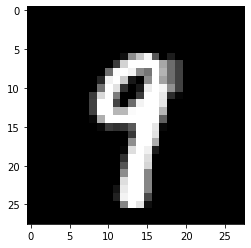

In [16]:
plt.imshow(picture, cmap='gray')
print("Target Label: ", target.item())
print("Predicted Label: ", pred_label.item())

In [35]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        #If prediction is already wrong go to next item
        if init_pred.item() != target.item():
            continue
        
        #Creates Adversarial Image
        for i in range(10):
            loss = F.cross_entropy(output, torch.tensor([5]).to(device))

            model.zero_grad()
            loss.backward()

            data_grad = data.grad.data

            perturbed_image = data - epsilon*data_grad

            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            output = model(perturbed_image)

        final_pred = output.max(1, keepdim=True)[1]

        #Adds adversarial examples if wrong
        if final_pred.item() == target.item():
            correct += 1

            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [36]:
%%time
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3, .5, .75]
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9544 / 10000 = 0.9544
Epsilon: 0.1	Test Accuracy = 7557 / 10000 = 0.7557
Epsilon: 0.15	Test Accuracy = 4365 / 10000 = 0.4365
Epsilon: 0.2	Test Accuracy = 2634 / 10000 = 0.2634
Epsilon: 0.25	Test Accuracy = 1813 / 10000 = 0.1813
Epsilon: 0.3	Test Accuracy = 1408 / 10000 = 0.1408
Epsilon: 0.5	Test Accuracy = 944 / 10000 = 0.0944
Epsilon: 0.75	Test Accuracy = 885 / 10000 = 0.0885


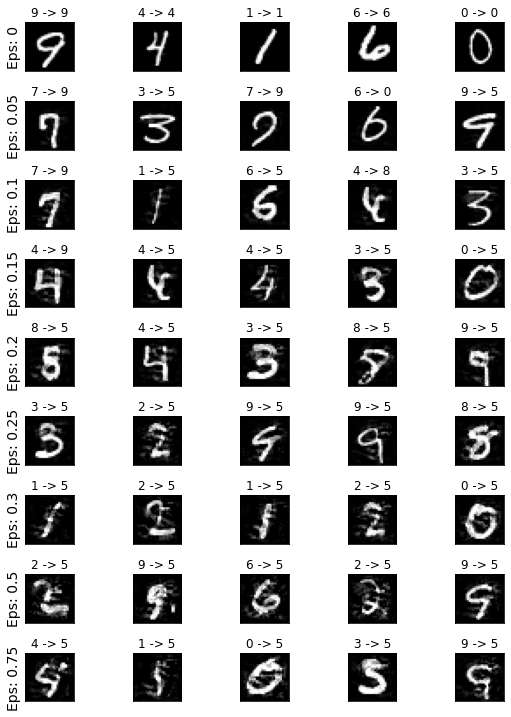

In [37]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

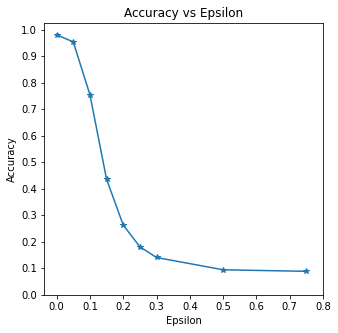

In [38]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .85, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Original:  8 
Adversarial: 5


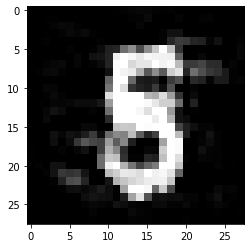

In [49]:
orig, adv, img = examples[4][0]
plt.imshow(img, cmap='gray')
print("Original: ", orig, "\nAdversarial:", adv)